In [1]:
from pathlib import Path
from model_settings import ms
import pandas as pd
import sys
import os
import numpy as np
from model_settings import ms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
from datetime import timedelta
import QuantLib as ql
from itertools import product


pricing settings:
Actual/365 (Fixed) day counter
New York stock exchange calendar
compounding: continuous
frequency: annual



In [2]:
jupyter_dir = os.path.abspath(str(Path()))
os.chdir(jupyter_dir)

In [3]:
store = pd.HDFStore(r'alphaVantage Vanillas.h5')
keys = store.keys()
len(keys)

3000

In [4]:
contract_keys = [key for key in keys if key.find('hottest_contracts')!= -1]
len(contract_keys)

1000

In [5]:
surface_keys = [key for key in keys if key.find('surface')!= -1]
len(surface_keys)

1000

In [6]:
raw_data_keys = [key for key in keys if key.find('raw_data')!=-1]
len(raw_data_keys)

1000

# Routine Start

In [7]:
surface_key = surface_keys[1]
surface_key

'/date_2024_10_08/surface'

## loop start

In [8]:
second_backslash_pos = surface_key.find('/', 1)
date_key_component = surface_key[:second_backslash_pos+1]
date_key_component

'/date_2024_10_08/'

In [9]:
accomp = [key for key in contract_keys if f'{date_key_component}hottest_contracts' in contract_keys][0]
accomp

'/date_2024_10_09/hottest_contracts'

In [10]:
raw_data_key = [key for key in raw_data_keys if f'{date_key_component}raw_data' in raw_data_keys][0]
raw_data_key

'/date_2024_10_09/raw_data'

In [11]:
date_string = date_key_component[date_key_component.find('_',0)+1:date_key_component.find('_',0)+11]
date_string

'2024_10_08'

In [12]:
calculation_datetime = datetime.strptime(date_string,'%Y_%m_%d')
calculation_datetime

datetime.datetime(2024, 10, 8, 0, 0)

In [13]:
raw_data = pd.DataFrame(store[raw_data_key])
raw_data.iloc[:5,:]

,contractID,symbol,expiration,strike,type,last,mark,bid,bid_size,ask,ask_size,volume,open_interest,date,implied_volatility,delta,gamma,theta,vega,rho
0,SPY241009C00300000,SPY,2024-10-09,300.00,call,273.09,276.56,275.94,40,277.17,50,13,0,2024-10-09,3.85357,1.00000,0.00000,-0.14488,0.00000,0.00822
1,SPY241009P00300000,SPY,2024-10-09,300.00,put,0.01,0.01,0.00,0,0.01,2300,1,0,2024-10-09,3.77630,-0.00033,0.00001,-0.24808,0.00036,-0.00001
2,SPY241009C00305000,SPY,2024-10-09,305.00,call,0.00,271.56,270.94,40,272.17,50,0,0,2024-10-09,3.78404,1.00000,0.00000,-0.14730,0.00000,0.00836
3,SPY241009P00305000,SPY,2024-10-09,305.00,put,0.00,0.01,0.00,0,0.11,1,0,0,2024-10-09,3.68560,-0.00033,0.00001,-0.24760,0.00037,-0.00001
4,SPY241009C00310000,SPY,2024-10-09,310.00,call,0.00,266.56,265.94,40,267.17,50,0,0,2024-10-09,3.71452,1.00000,0.00000,-0.14971,0.00000,0.00849


In [14]:
pd.to_numeric(raw_data['last'])

0       273.09
1         0.01
2         0.00
3         0.00
4         0.00
         ...  
9801      0.00
9802      1.31
9803      0.00
9804      1.19
9805      0.00
Name: last, Length: 9806, dtype: float64

In [15]:
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data['expiration'] = pd.to_datetime(raw_data['expiration'])
raw_data['implied_volatility'] = pd.to_numeric(raw_data['implied_volatility'])
raw_data['strike'] = pd.to_numeric(raw_data['strike'])
raw_data['last'] = pd.to_numeric(raw_data['last'])
raw_data.dtypes

contractID                    object
symbol                        object
expiration            datetime64[ns]
strike                       float64
type                          object
last                         float64
mark                          object
bid                           object
bid_size                      object
ask                           object
ask_size                      object
volume                        object
open_interest                 object
date                  datetime64[ns]
implied_volatility           float64
delta                         object
gamma                         object
theta                         object
vega                          object
rho                           object
dtype: object

In [16]:
contract_maturities = np.array((raw_data['expiration'] - raw_data['date']) / timedelta(days=1)).astype(int)
raw_data['days_to_maturity'] = contract_maturities
raw_data.iloc[:5,:]

,contractID,symbol,expiration,strike,type,last,mark,bid,bid_size,ask,...,volume,open_interest,date,implied_volatility,delta,gamma,theta,vega,rho,days_to_maturity
0,SPY241009C00300000,SPY,2024-10-09,300.0,call,273.09,276.56,275.94,40,277.17,...,13,0,2024-10-09,3.85357,1.00000,0.00000,-0.14488,0.00000,0.00822,0
1,SPY241009P00300000,SPY,2024-10-09,300.0,put,0.01,0.01,0.00,0,0.01,...,1,0,2024-10-09,3.77630,-0.00033,0.00001,-0.24808,0.00036,-0.00001,0
2,SPY241009C00305000,SPY,2024-10-09,305.0,call,0.00,271.56,270.94,40,272.17,...,0,0,2024-10-09,3.78404,1.00000,0.00000,-0.14730,0.00000,0.00836,0
3,SPY241009P00305000,SPY,2024-10-09,305.0,put,0.00,0.01,0.00,0,0.11,...,0,0,2024-10-09,3.68560,-0.00033,0.00001,-0.24760,0.00037,-0.00001,0
4,SPY241009C00310000,SPY,2024-10-09,310.0,call,0.00,266.56,265.94,40,267.17,...,0,0,2024-10-09,3.71452,1.00000,0.00000,-0.14971,0.00000,0.00849,0


In [17]:
vol_matrix = pd.DataFrame(store[surface_key])
vol_matrix

,31,38,52,73,84,101,115,164,346
500.0,0.31159,0.29803,0.27851,0.26617,0.25839,0.25336,0.24940,0.24071,0.23080
510.0,0.29117,0.27928,0.26144,0.25199,0.24513,0.24086,0.23751,0.23095,0.22486
520.0,0.27013,0.26098,0.24544,0.23827,0.23217,0.22882,0.22608,0.22120,0.21907
525.0,0.26083,0.25199,0.23781,0.23156,0.22577,0.22288,0.22013,0.21632,0.21617
530.0,0.25138,0.24330,0.23004,0.22486,0.21983,0.21693,0.21464,0.21160,0.21342
540.0,0.23278,0.22608,0.21495,0.21160,0.20718,0.20519,0.20352,0.20199,0.20748
550.0,0.21495,0.20931,0.20016,0.19818,0.19452,0.19330,0.19239,0.19254,0.20169
555.0,0.20580,0.20077,0.19254,0.19147,0.18812,0.18751,0.18690,0.18797,0.19894
560.0,0.19650,0.19224,0.18492,0.18461,0.18187,0.18187,0.18157,0.18355,0.19620
565.0,0.18705,0.18340,0.17745,0.17791,0.17577,0.17608,0.17623,0.17928,0.19346


In [18]:
contracts = pd.DataFrame(store[accomp])
contracts.iloc[:5,:]

,days_to_maturity,strike_price,volume,contractID,symbol,expiration,type,last,mark,bid,...,open_interest,date,implied_volatility,delta,gamma,theta,vega,rho,spot_price,moneyness
0,37,590.0,67397.0,SPY241115C00590000,SPY,2024-11-15,call,6.12,6.11,6.08,...,12092.0,2024-10-09,0.13995,0.35852,0.01453,-0.57086,0.68647,0.20355,577.14,-0.021797
1,72,605.0,64064.0,SPY241220C00605000,SPY,2024-12-20,call,4.87,4.85,4.82,...,6212.0,2024-10-09,0.12501,0.25794,0.01008,-0.33194,0.82803,0.28409,577.14,-0.046050
2,72,560.0,17404.0,SPY241220P00560000,SPY,2024-12-20,put,9.45,9.53,9.51,...,26576.0,2024-10-09,0.18599,-0.30097,0.00730,-0.33227,0.89254,-0.36144,577.14,-0.029698
3,100,620.0,16420.0,SPY250117C00620000,SPY,2025-01-17,call,3.20,3.12,3.10,...,6897.0,2024-10-09,0.11465,0.17279,0.00738,-0.20827,0.77243,0.26465,577.14,-0.069129
4,37,545.0,11945.0,SPY241115P00545000,SPY,2024-11-15,put,3.97,3.98,3.96,...,37018.0,2024-10-09,0.21907,-0.17707,0.00645,-0.46435,0.47721,-0.10762,577.14,-0.055688


In [19]:
contracts['spot_price'].unique()

array([577.14])

In [20]:
spot = float(contracts['spot_price'].unique()[0])
spot

577.14

In [21]:
T = vol_matrix.columns.tolist()
K = vol_matrix.index.tolist()
print(f"\nmaturitites:\n     {T}\nstrikes:\n     {K}\n")


maturitites:
     [31, 38, 52, 73, 84, 101, 115, 164, 346]
strikes:
     [500.0, 510.0, 520.0, 525.0, 530.0, 540.0, 550.0, 555.0, 560.0, 565.0, 570.0, 575.0, 580.0, 585.0, 590.0, 600.0, 605.0]



In [22]:
calculation_date = ql.Date(
    calculation_datetime.day,
    calculation_datetime.month,
    calculation_datetime.year)
print(calculation_date)

October 8th, 2024


In [23]:
r = 0.04
g = 0.018

In [24]:
s = spot
s

577.14

In [25]:
ql.Settings.instance().evaluationDate = calculation_date
flat_ts, dividend_ts = ms.ql_ts_rg(r, g, calculation_date)
S_handle = ql.QuoteHandle(ql.SimpleQuote(s))

heston_helpers = []
v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; eta = 0.5;
process = ql.HestonProcess(
    flat_ts,
    dividend_ts,
    S_handle,
    v0,                # Initial volatility
    kappa,             # Mean reversion speed
    theta,             # Long-run variance (volatility squared)
    eta,               # Volatility of the volatility
    rho                # Correlation between asset and volatility
)
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model)

for t in T:
    for k in K:
        p = ql.Period(int(t),ql.Days)
        volatility = vol_matrix.loc[k,t]
        helper = ql.HestonModelHelper(
            p, ms.calendar, float(s), k, 
            ql.QuoteHandle(ql.SimpleQuote(volatility)), 
            flat_ts, 
            dividend_ts
            )
        helper.setPricingEngine(engine)
        heston_helpers.append(helper)

lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)


model.calibrate(heston_helpers, lm,
                  ql.EndCriteria(1000, 50, 1.0e-8,1.0e-8, 1.0e-8))

theta, kappa, eta, rho, v0 = model.params()
heston_parameters = pd.Series(
    [theta, kappa, eta, rho, v0],
    index = ['theta', 'kappa', 'eta', 'rho', 'v0'],
    dtype = float
)
print(heston_parameters)

theta    0.213263
kappa    0.336359
eta      1.356718
rho     -0.709446
v0       0.036446
dtype: float64


# Plotting

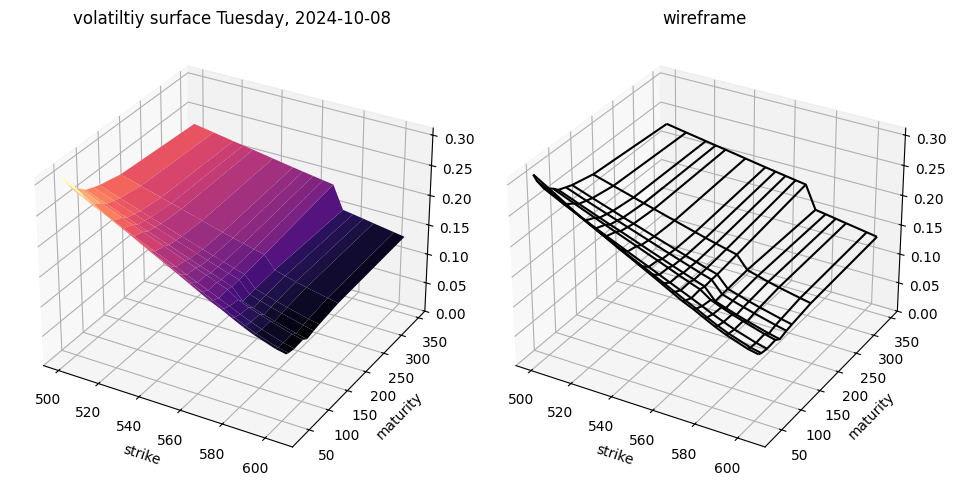

<Figure size 640x480 with 0 Axes>

In [26]:
printdate = calculation_datetime.strftime('%A, %Y-%m-%d')
KK,TT = np.meshgrid(K,T)
VV = np.array(
        [[vol_matrix.loc[k,t] for k in K] for t in T]
        )
fig = plt.figure(figsize=plt.figaspect(0.5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax1.plot_surface(KK, TT, VV, rstride=1, cstride=1, cmap=cm.magma, linewidth=0.1)


ax1.set_zlim(0, float(max(vol_matrix.values.flatten())))
ax1.set_title(f"volatiltiy surface {printdate}")
ax1.set_xlabel('strike')
ax1.set_ylabel('maturity')

# Second subplot for wireframe plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_wireframe(KK, TT, VV, rstride=1, cstride=1,color='black')
ax2.set_zlim(0, float(max(vol_matrix.values.flatten())))
ax2.set_title('wireframe')
ax2.set_xlabel('strike')
ax2.set_ylabel('maturity')
plt.tight_layout()
plt.show()
plt.clf()

# Testing

In [27]:
raw_data

,contractID,symbol,expiration,strike,type,last,mark,bid,bid_size,ask,...,volume,open_interest,date,implied_volatility,delta,gamma,theta,vega,rho,days_to_maturity
0,SPY241009C00300000,SPY,2024-10-09,300.0,call,273.09,276.56,275.94,40,277.17,...,13,0,2024-10-09,3.85357,1.00000,0.00000,-0.14488,0.00000,0.00822,0
1,SPY241009P00300000,SPY,2024-10-09,300.0,put,0.01,0.01,0.00,0,0.01,...,1,0,2024-10-09,3.77630,-0.00033,0.00001,-0.24808,0.00036,-0.00001,0
2,SPY241009C00305000,SPY,2024-10-09,305.0,call,0.00,271.56,270.94,40,272.17,...,0,0,2024-10-09,3.78404,1.00000,0.00000,-0.14730,0.00000,0.00836,0
3,SPY241009P00305000,SPY,2024-10-09,305.0,put,0.00,0.01,0.00,0,0.11,...,0,0,2024-10-09,3.68560,-0.00033,0.00001,-0.24760,0.00037,-0.00001,0
4,SPY241009C00310000,SPY,2024-10-09,310.0,call,0.00,266.56,265.94,40,267.17,...,0,0,2024-10-09,3.71452,1.00000,0.00000,-0.14971,0.00000,0.00849,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9801,SPY270115P00890000,SPY,2027-01-15,890.0,put,0.00,313.46,311.00,10,315.92,...,0,0,2024-10-09,0.45412,-0.55215,0.00100,-0.03883,3.43818,-14.33941,828
9802,SPY270115C00895000,SPY,2027-01-15,895.0,call,1.31,1.84,0.31,138,3.38,...,0,2,2024-10-09,0.12227,0.04500,0.00089,-0.03386,0.82396,0.54743,828
9803,SPY270115P00895000,SPY,2027-01-15,895.0,put,0.00,318.46,316.00,10,320.92,...,0,0,2024-10-09,0.45839,-0.55234,0.00099,-0.03956,3.43796,-14.45592,828
9804,SPY270115C00900000,SPY,2027-01-15,900.0,call,1.19,1.16,1.15,3,1.17,...,49,402,2024-10-09,0.11449,0.03180,0.00072,-0.02397,0.62075,0.38997,828


In [28]:
contracts.iloc[:5,:]

,days_to_maturity,strike_price,volume,contractID,symbol,expiration,type,last,mark,bid,...,open_interest,date,implied_volatility,delta,gamma,theta,vega,rho,spot_price,moneyness
0,37,590.0,67397.0,SPY241115C00590000,SPY,2024-11-15,call,6.12,6.11,6.08,...,12092.0,2024-10-09,0.13995,0.35852,0.01453,-0.57086,0.68647,0.20355,577.14,-0.021797
1,72,605.0,64064.0,SPY241220C00605000,SPY,2024-12-20,call,4.87,4.85,4.82,...,6212.0,2024-10-09,0.12501,0.25794,0.01008,-0.33194,0.82803,0.28409,577.14,-0.046050
2,72,560.0,17404.0,SPY241220P00560000,SPY,2024-12-20,put,9.45,9.53,9.51,...,26576.0,2024-10-09,0.18599,-0.30097,0.00730,-0.33227,0.89254,-0.36144,577.14,-0.029698
3,100,620.0,16420.0,SPY250117C00620000,SPY,2025-01-17,call,3.20,3.12,3.10,...,6897.0,2024-10-09,0.11465,0.17279,0.00738,-0.20827,0.77243,0.26465,577.14,-0.069129
4,37,545.0,11945.0,SPY241115P00545000,SPY,2024-11-15,put,3.97,3.98,3.96,...,37018.0,2024-10-09,0.21907,-0.17707,0.00645,-0.46435,0.47721,-0.10762,577.14,-0.055688


In [29]:
calibration_test_data = raw_data.copy()[['strike','type','last','implied_volatility','days_to_maturity']]
calibration_test_data.columns = ['strike_price','w','market_price','volatility','days_to_maturity']
calibration_test_data['spot_price'] = s
calibration_test_data['risk_free_rate'] = r
calibration_test_data['dividend_rate'] = g
calibration_test_data = calibration_test_data[calibration_test_data['days_to_maturity'].isin(contracts['days_to_maturity'])]
calibration_test_data = calibration_test_data[calibration_test_data['days_to_maturity'].isin(contracts['days_to_maturity'])]
calibration_test_data.dtypes

strike_price        float64
w                    object
market_price        float64
volatility          float64
days_to_maturity      int64
spot_price          float64
risk_free_rate      float64
dividend_rate       float64
dtype: object

In [30]:
calibration_test_data

,strike_price,w,market_price,volatility,days_to_maturity,spot_price,risk_free_rate,dividend_rate
3584,325.0,call,0.00,0.22619,30,577.14,0.04,0.018
3585,325.0,put,0.09,0.74085,30,577.14,0.04,0.018
3586,330.0,call,0.00,0.74603,30,577.14,0.04,0.018
3587,330.0,put,0.10,0.73049,30,577.14,0.04,0.018
3588,335.0,call,0.00,0.73963,30,577.14,0.04,0.018
...,...,...,...,...,...,...,...,...
6479,810.0,put,0.00,0.47622,163,577.14,0.04,0.018
6480,815.0,call,0.03,0.16236,163,577.14,0.04,0.018
6481,815.0,put,0.00,0.48278,163,577.14,0.04,0.018
6482,820.0,call,0.03,0.16510,163,577.14,0.04,0.018


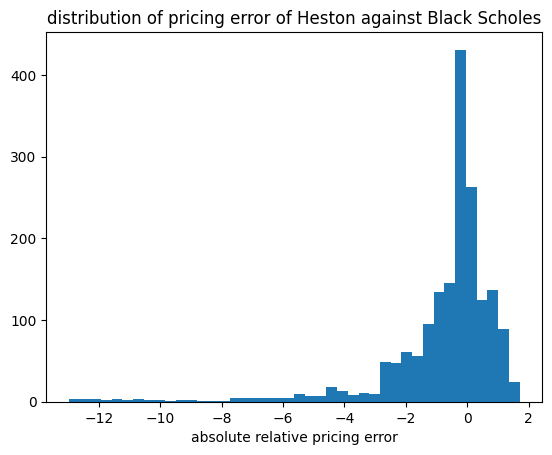

<Figure size 640x480 with 0 Axes>

In [31]:
calibration_test_data[heston_parameters.index.tolist()] = np.tile(heston_parameters,(calibration_test_data.shape[0],1))
calibration_test_data.loc[:,'moneyness'] = ms.vmoneyness(calibration_test_data['spot_price'].values,calibration_test_data['strike_price'].values,calibration_test_data['w'].values)
calibration_test_data['calculation_date'] = calculation_datetime
calibration_test_data['black_scholes'] = ms.vector_black_scholes(calibration_test_data)
calibration_test_data['heston_price'] = ms.vector_heston_price(calibration_test_data)
calibration_test_data.loc[:,'absolute_error'] = calibration_test_data['heston_price'].values - calibration_test_data['black_scholes'].values
plt.figure()
plt.hist(calibration_test_data['absolute_error'],bins=int(calibration_test_data.shape[0]**(1/2)))
plt.xlabel('absolute relative pricing error')
plt.title('distribution of pricing error of Heston against Black Scholes')
plt.show()
plt.clf()

In [41]:
large_errors = calibration_test_data.copy()[calibration_test_data['absolute_error']>=1]
pd.set_option("display.max_rows",None)
print(large_errors.describe())

       strike_price  market_price  volatility  days_to_maturity    spot_price  \
count    113.000000    113.000000  113.000000        113.000000  1.130000e+02   
mean     527.743363      5.725841    0.222604         89.469027  5.771400e+02   
min      425.000000      0.000000    0.112210         51.000000  5.771400e+02   
25%      520.000000      4.320000    0.201840         51.000000  5.771400e+02   
50%      536.000000      5.570000    0.217540         72.000000  5.771400e+02   
75%      548.000000      7.200000    0.233090        100.000000  5.771400e+02   
max      665.000000     12.290000    0.320740        163.000000  5.771400e+02   
std       34.597631      2.239622    0.032889         43.404878  1.141932e-13   

       risk_free_rate  dividend_rate         theta         kappa  \
count    1.130000e+02   1.130000e+02  1.130000e+02  1.130000e+02   
mean     4.000000e-02   1.800000e-02  2.132628e-01  3.363589e-01   
min      4.000000e-02   1.800000e-02  2.132628e-01  3.363589e-01  

In [38]:
pd.reset_option("display.max_rows")